In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score

In [4]:
df=pd.read_csv("https://raw.githubusercontent.com/wri/global-power-plant-database/master/source_databases_csv/database_IND.csv")
df.head()

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,generation_data_source,estimated_generation_gwh
0,IND,India,ACME Solar Tower,WRI1020239,2.5,28.1839,73.2407,Solar,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IND,India,ADITYA CEMENT WORKS,WRI1019881,98.0,24.7663,74.6090,Coal,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IND,India,AES Saurashtra Windfarms,WRI1026669,39.2,21.9038,69.3732,Wind,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IND,India,AGARTALA GT,IND0000001,135.0,23.8712,91.3602,Gas,NaN,NaN,...,2019.0,NaN,617.789264,843.747,886.004428,663.774500,626.239128,NaN,Central Electricity Authority,NaN
4,IND,India,AKALTARA TPP,IND0000002,1800.0,21.9603,82.4091,Coal,Oil,NaN,...,2019.0,NaN,3035.550000,5916.370,6243.000000,5385.579736,7279.000000,NaN,Central Electricity Authority,NaN


## Exploratory Data Analysis

## Checking nulls

In [4]:
df.isna().sum()

country                       0
country_long                  0
name                          0
gppd_idnr                     0
capacity_mw                   0
latitude                     46
longitude                    46
primary_fuel                  0
other_fuel1                 709
other_fuel2                 906
other_fuel3                 907
commissioning_year          380
owner                       565
source                        0
url                           0
geolocation_source           19
wepp_id                     907
year_of_capacity_data       388
generation_gwh_2013         907
generation_gwh_2014         509
generation_gwh_2015         485
generation_gwh_2016         473
generation_gwh_2017         467
generation_gwh_2018         459
generation_gwh_2019         907
generation_data_source      458
estimated_generation_gwh    907
dtype: int64

## Data types of each feature

In [5]:
df.dtypes

country                      object
country_long                 object
name                         object
gppd_idnr                    object
capacity_mw                 float64
latitude                    float64
longitude                   float64
primary_fuel                 object
other_fuel1                  object
other_fuel2                  object
other_fuel3                 float64
commissioning_year          float64
owner                        object
source                       object
url                          object
geolocation_source           object
wepp_id                     float64
year_of_capacity_data       float64
generation_gwh_2013         float64
generation_gwh_2014         float64
generation_gwh_2015         float64
generation_gwh_2016         float64
generation_gwh_2017         float64
generation_gwh_2018         float64
generation_gwh_2019         float64
generation_data_source       object
estimated_generation_gwh    float64
dtype: object

In [12]:
df.shape

(907, 22)

## In predicting capacity_mw as well as primary_fuel we dont need the source,url, geolocation_source, year_of_capacity_data and generation_data_source as these all features represent the source of this information.

In [5]:
#Droping source, url, geolocation_source
df=df.drop(['source','url','geolocation_source','generation_data_source','year_of_capacity_data'],axis=1)

In [8]:
#Checking unique values of country and country_long
df['country'].value_counts()

IND    907
Name: country, dtype: int64

In [9]:
df['country_long'].value_counts()

India    907
Name: country_long, dtype: int64

## It seems that this data is for India country only and not global dataset so we dont need these 2 columns for analysis thus we will drop them as well.

In [6]:
df=df.drop(['country','country_long'],axis=1)

In [11]:
df['wepp_id']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
902   NaN
903   NaN
904   NaN
905   NaN
906   NaN
Name: wepp_id, Length: 907, dtype: float64

## There are few features that are all nulls so we could not replace null by any of the relevant values thus we would drop it as they would not contribute in predicting any label.

In [7]:
# We will drop other_fuel2,other_fuel3,wepp_id,generation_gwh_2013,generation_gwh_2019, estimated_generation_gwh
df=df.drop(['other_fuel2','other_fuel3','wepp_id','generation_gwh_2013','generation_gwh_2019','estimated_generation_gwh'],axis=1)

In [31]:
df.head()

,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018
0,ACME Solar Tower,WRI1020239,2.5,28.1839,73.2407,Solar,NaN,2011.0,Solar Paces,NaN,NaN,NaN,NaN,NaN
1,ADITYA CEMENT WORKS,WRI1019881,98.0,24.7663,74.6090,Coal,NaN,NaN,Ultratech Cement ltd,NaN,NaN,NaN,NaN,NaN
2,AES Saurashtra Windfarms,WRI1026669,39.2,21.9038,69.3732,Wind,NaN,NaN,AES,NaN,NaN,NaN,NaN,NaN
3,AGARTALA GT,IND0000001,135.0,23.8712,91.3602,Gas,NaN,2004.0,NaN,617.789264,843.747,886.004428,663.774500,626.239128
4,AKALTARA TPP,IND0000002,1800.0,21.9603,82.4091,Coal,Oil,2015.0,NaN,3035.550000,5916.370,6243.000000,5385.579736,7279.000000


In [32]:
#Checking nulls again
df.isna().sum()

name                     0
gppd_idnr                0
capacity_mw              0
latitude                46
longitude               46
primary_fuel             0
other_fuel1            709
commissioning_year     380
owner                  565
generation_gwh_2014    509
generation_gwh_2015    485
generation_gwh_2016    473
generation_gwh_2017    467
generation_gwh_2018    459
dtype: int64

## Treating nulls

In [8]:
df['latitude']=df['latitude'].fillna(df['latitude'].mean())

In [9]:
df['longitude']=df['longitude'].fillna(df['longitude'].mean())

In [10]:
df['other_fuel1'].value_counts()

Oil             195
Gas               2
Cogeneration      1
Name: other_fuel1, dtype: int64

In [11]:
df['other_fuel1']=df['other_fuel1'].fillna('Oil')

In [152]:
df['commissioning_year'].value_counts()

2015.0    28
2013.0    25
2012.0    23
2016.0    19
2010.0    18
          ..
1946.0     1
1956.0     1
1937.0     1
1949.0     1
1953.0     1
Name: commissioning_year, Length: 73, dtype: int64

In [12]:
df['commissioning_year']=df['commissioning_year'].fillna(2015.0)

# Since we dont know the onwer of 565 plants so we will just fill it with others as filling these nulls with the most occuring owner name wont be a good idea and could impact our result

In [13]:
df['owner']=df['owner'].fillna('others')

In [14]:
df['generation_gwh_2014']=df['generation_gwh_2014'].fillna(df['generation_gwh_2014'].mean())
df['generation_gwh_2015']=df['generation_gwh_2015'].fillna(df['generation_gwh_2015'].mean())
df['generation_gwh_2016']=df['generation_gwh_2016'].fillna(df['generation_gwh_2016'].mean())
df['generation_gwh_2017']=df['generation_gwh_2017'].fillna(df['generation_gwh_2017'].mean())
df['generation_gwh_2018']=df['generation_gwh_2018'].fillna(df['generation_gwh_2018'].mean())

In [156]:
df.isna().sum()

name                   0
gppd_idnr              0
capacity_mw            0
latitude               0
longitude              0
primary_fuel           0
other_fuel1            0
commissioning_year     0
owner                  0
generation_gwh_2014    0
generation_gwh_2015    0
generation_gwh_2016    0
generation_gwh_2017    0
generation_gwh_2018    0
dtype: int64

## Encoding

In [15]:
oe=OrdinalEncoder()
df1=oe.fit_transform(df[['name']])
df['name']=df1
df2=oe.fit_transform(df[['gppd_idnr']])
df['gppd_idnr']=df2
df3=oe.fit_transform(df[['owner']])
df['owner']=df3
df.head()

le=LabelEncoder()
df1=le.fit_transform(df[['primary_fuel']])
df['primary_fuel']=df1
df2=le.fit_transform(df[['other_fuel1']])
df['other_fuel1']=df2

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [16]:
df.head()

,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018
0,0.0,657.0,2.5,28.1839,73.2407,6,2,2011.0,229.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
1,1.0,519.0,98.0,24.7663,74.6090,1,2,2015.0,258.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
2,2.0,853.0,39.2,21.9038,69.3732,7,2,2015.0,2.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
3,3.0,0.0,135.0,23.8712,91.3602,2,2,2004.0,280.0,617.789264,843.747000,886.004428,663.774500,626.239128
4,4.0,1.0,1800.0,21.9603,82.4091,1,2,2015.0,280.0,3035.550000,5916.370000,6243.000000,5385.579736,7279.000000


## Visualizing features with respect to label capacity_mw

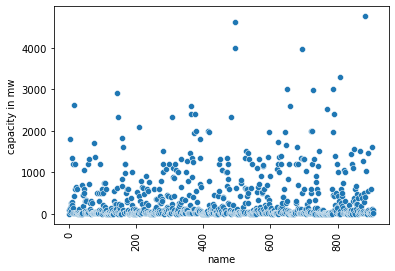

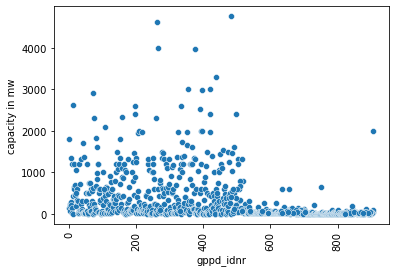

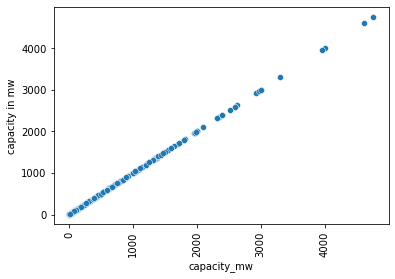

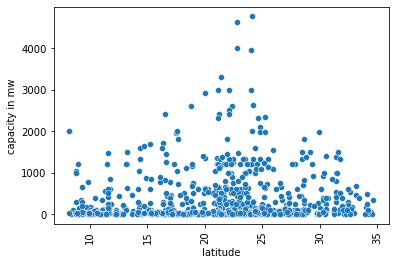

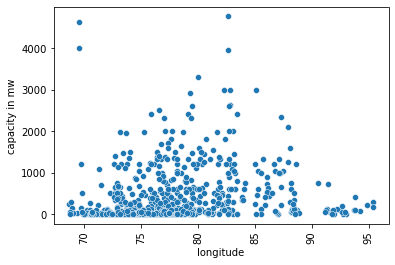

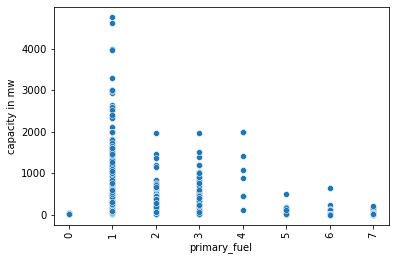

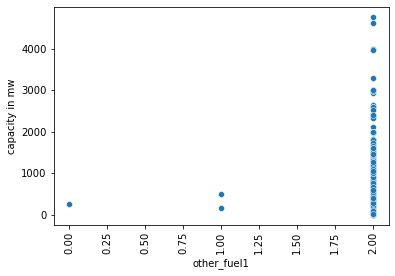

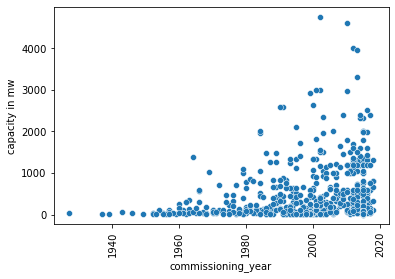

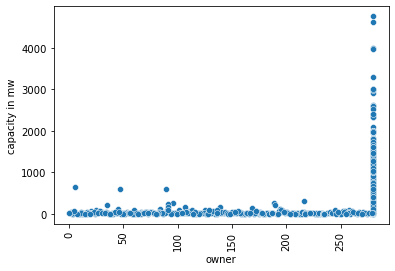

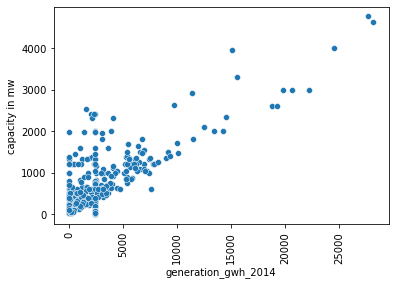

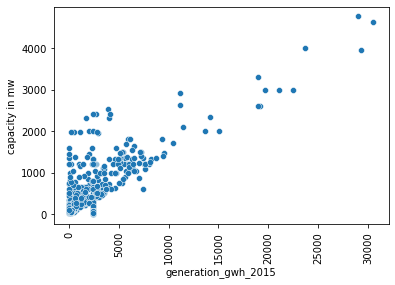

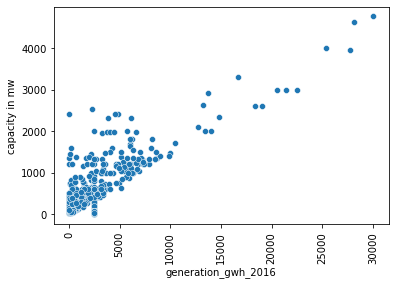

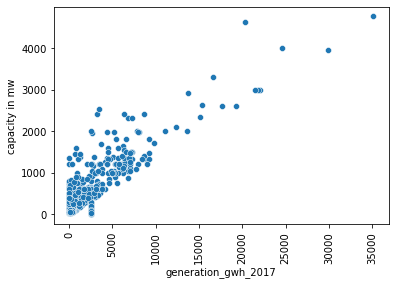

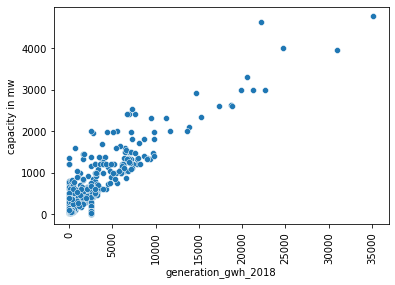

In [52]:
col=df.columns
for i in col:
    sns.scatterplot(x=i,y='capacity_mw',data=df)
    plt.xlabel(i)
    plt.xticks(rotation=90)
    plt.ylabel("capacity in mw")
    plt.show()

In [229]:
#Combining generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018 into
#one feature generation_gwh
df['generation_gwh']=df.iloc[:, [9,10,11,12,13]].mean(axis=1)

In [57]:
df.head()

,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh
0,0.0,657.0,2.5,28.1839,73.2407,6,2,2011.0,229.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099,2495.310160
1,1.0,519.0,98.0,24.7663,74.6090,1,2,2015.0,258.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099,2495.310160
2,2.0,853.0,39.2,21.9038,69.3732,7,2,2015.0,2.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099,2495.310160
3,3.0,0.0,135.0,23.8712,91.3602,2,2,2004.0,280.0,617.789264,843.747000,886.004428,663.774500,626.239128,727.510864
4,4.0,1.0,1800.0,21.9603,82.4091,1,2,2015.0,280.0,3035.550000,5916.370000,6243.000000,5385.579736,7279.000000,5571.899947


In [230]:
df=df.drop(['generation_gwh_2014','generation_gwh_2015','generation_gwh_2016','generation_gwh_2017','generation_gwh_2018'],axis=1)

## Describing the data

In [60]:
df.describe()

,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,generation_gwh
count,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000
mean,453.000000,453.000000,326.223755,21.197918,77.464907,3.206174,1.995590,2004.594267,227.476295,2495.310160
std,261.972645,261.972645,590.085456,6.079148,4.812291,2.280652,0.081259,15.734928,83.924045,2799.906617
min,0.000000,0.000000,0.000000,8.168900,68.644700,0.000000,0.000000,1927.000000,0.000000,0.000000
25%,226.500000,226.500000,16.725000,17.072000,74.388900,1.000000,2.000000,1998.000000,188.500000,1133.283240
50%,453.000000,453.000000,59.200000,21.281800,76.979200,3.000000,2.000000,2014.000000,280.000000,2495.310160
75%,679.500000,679.500000,385.250000,25.176450,79.206100,6.000000,2.000000,2015.000000,280.000000,2495.310160
max,906.000000,906.000000,4760.000000,34.649000,95.408000,7.000000,2.000000,2018.000000,280.000000,31381.600000


## Checking correlation

In [61]:
df.corr().abs()

,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,generation_gwh
name,1.000000,0.332205,0.060240,0.135247,0.020279,0.040753,0.074663,0.041465,1.179542e-01,7.438939e-02
gppd_idnr,0.332205,1.000000,0.335742,0.105728,0.377812,0.609180,0.002333,0.511350,6.020381e-01,3.088824e-02
capacity_mw,0.060240,0.335742,1.000000,0.050984,0.195882,0.380395,0.003105,0.004072,3.043221e-01,7.555775e-01
latitude,0.135247,0.105728,0.050984,1.000000,0.036362,0.010204,0.036695,0.034519,7.220683e-03,3.559319e-02
longitude,0.020279,0.377812,0.195882,0.036362,1.000000,0.347948,0.030311,0.159025,2.784428e-01,3.054665e-02
primary_fuel,0.040753,0.609180,0.380395,0.010204,0.347948,1.000000,0.004912,0.164947,2.603893e-01,1.333935e-01
other_fuel1,0.074663,0.002333,0.003105,0.036695,0.030311,0.004912,1.000000,0.056437,3.400389e-02,2.875828e-02
commissioning_year,0.041465,0.511350,0.004072,0.034519,0.159025,0.164947,0.056437,1.000000,4.128898e-01,1.355923e-01
owner,0.117954,0.602038,0.304322,0.007221,0.278443,0.260389,0.034004,0.412890,1.000000e+00,1.357435e-16
generation_gwh,0.074389,0.030888,0.755577,0.035593,0.030547,0.133394,0.028758,0.135592,1.357435e-16,1.000000e+00


<AxesSubplot:>

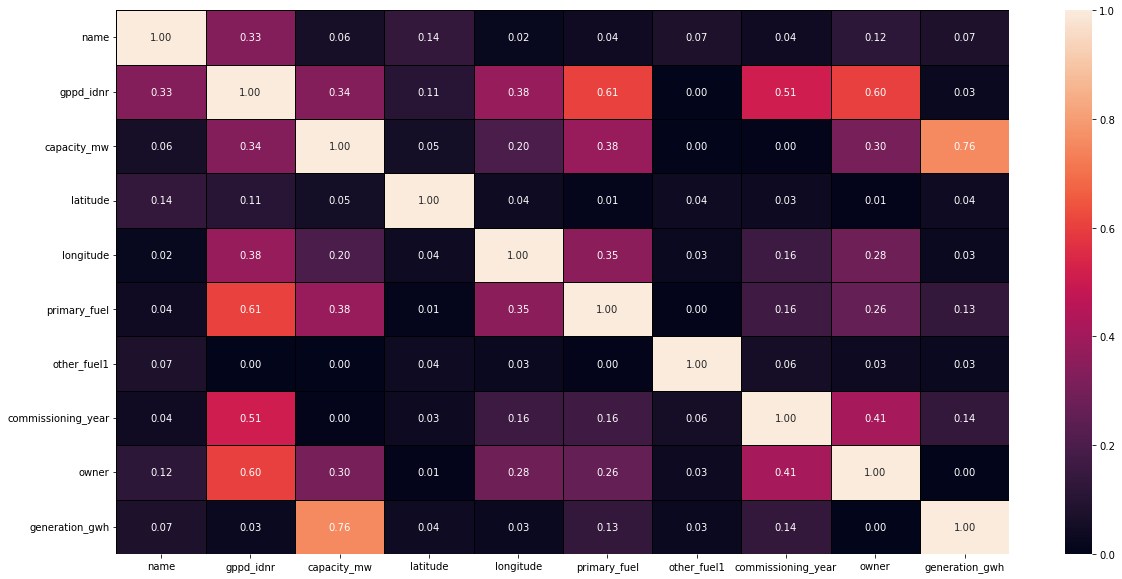

In [62]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr().abs(),annot=True,linewidth=0.5,linecolor='black',fmt='.2f')

observation:Multicollinearity doesnt exists.

## Checking Outliers

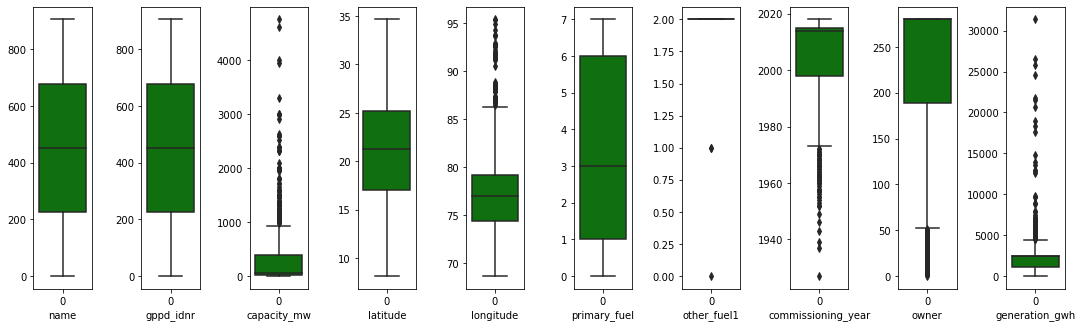

In [231]:
col=df.columns
plt.figure(figsize=(30,90))
for i in range(len(col)):
    plt.subplot(20,20,i+1)
    sns.boxplot(data=df[col[i]],color='green',orient='v')
    plt.xlabel(col[i])
    plt.tight_layout()

Observation: Outlier exists in longitude,commisioning_year and generation_gwh. Owner feature outlier should be ignored as it is a categorical feature.

## Checking skewness

In [66]:
df.skew()

name                   0.000000
gppd_idnr              0.000000
capacity_mw            3.123576
latitude              -0.149698
longitude              1.141881
primary_fuel           0.472251
other_fuel1          -20.453120
commissioning_year    -1.714873
owner                 -1.373940
generation_gwh         5.219383
dtype: float64

observation: Considering skewness range as (-0.5,0.5), we could observe longitude,commisioning_year and generation_gwh are skewed. Lets check by generating dist plot.

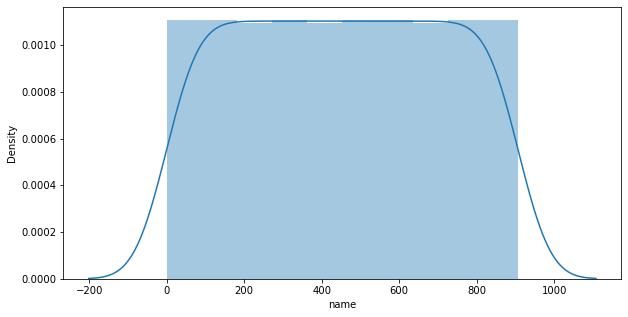

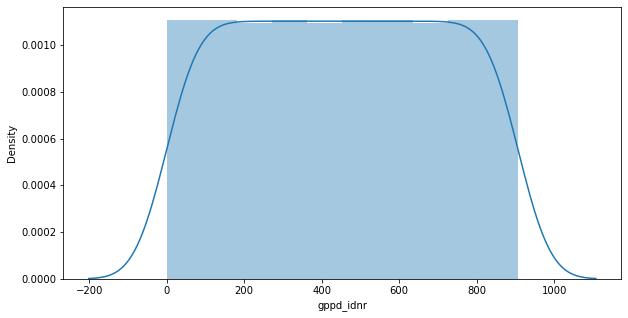

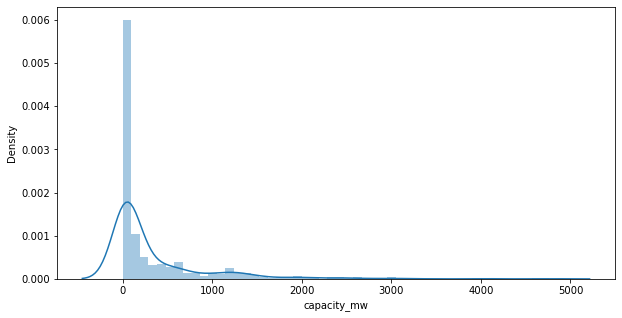

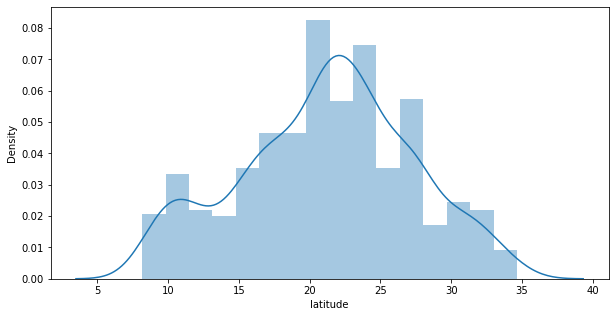

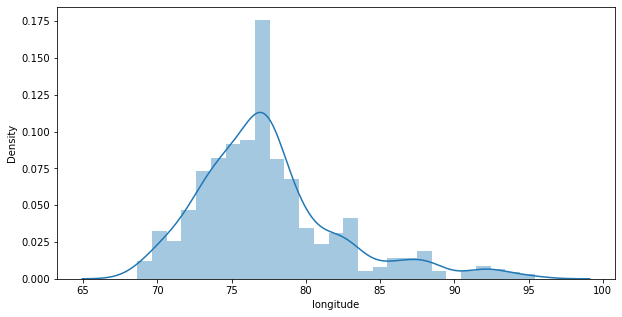

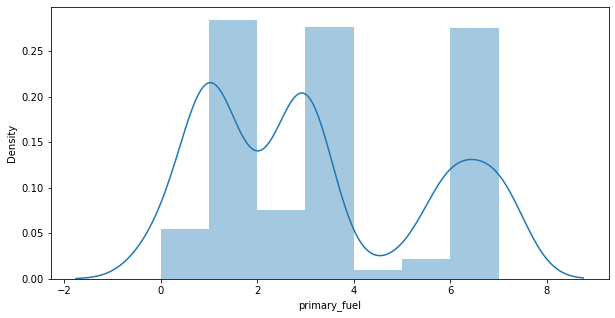

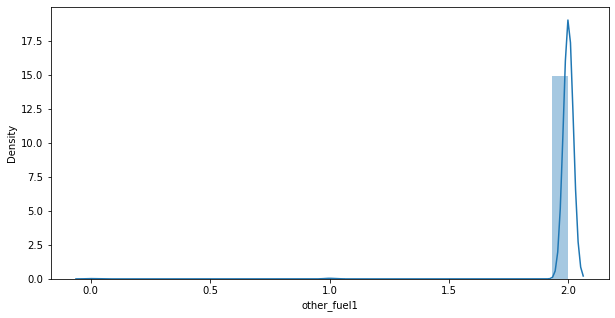

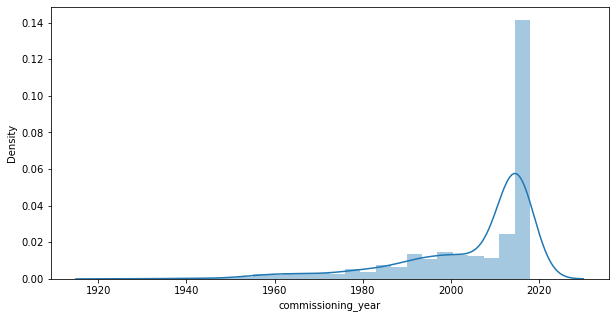

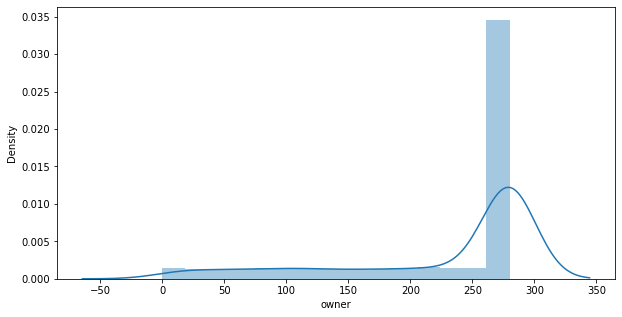

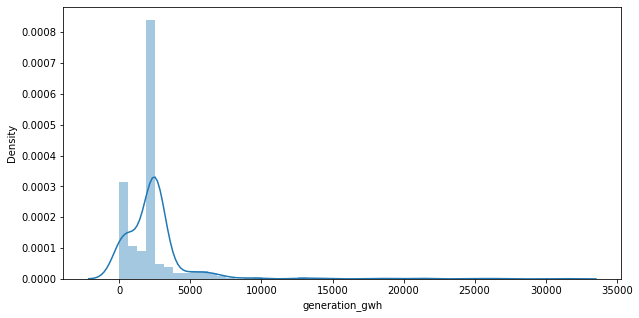

In [67]:
# Ploting Distribution plot to cross check skewness
import warnings
warnings.filterwarnings('ignore')
col=df.columns
# for feature Length
for i in range(len(df.columns)):
    plt.figure(figsize=(10,5))
    sns.distplot(df[col[i]])
    plt.xlabel(col[i],fontsize=10)
    

Our observation is correct.

## Treating outliers

In [160]:
x=df.drop(['capacity_mw'],axis=1)
y=df['capacity_mw']

In [161]:
z=np.abs(zscore(x))
i=np.where(z>3)
print("Outliers index-\n",set(i[0]))
print("\n\nNumber of rows to be eliminated-\n",len(set(i[0])))

Outliers index-
 {519, 648, 143, 15, 657, 786, 538, 541, 416, 546, 807, 808, 427, 811, 813, 817, 818, 179, 308, 183, 695, 444, 573, 577, 706, 323, 709, 454, 583, 333, 847, 848, 209, 721, 340, 724, 342, 726, 728, 601, 222, 478, 484, 360, 364, 493, 494, 621, 880, 371, 244, 499, 638}


Number of rows to be eliminated-
 53


In [162]:
#Calculating Data Loss
loss=((907-53)/907)*100
print("The data loss-",100-loss,"%")

The data loss- 5.843439911797134 %


Observation: If we remove outliers 5.8% of data will be lost so we could bear this loss and will remove outlier rows.

In [163]:
#removing rows with outliers
x=x.drop(x.index[i[0]])
x

,name,gppd_idnr,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,generation_gwh
0,0.0,657.0,28.1839,73.2407,6,2,2011.0,229.0,2495.310160
1,1.0,519.0,24.7663,74.6090,1,2,2015.0,258.0,2495.310160
2,2.0,853.0,21.9038,69.3732,7,2,2015.0,2.0,2495.310160
3,3.0,0.0,23.8712,91.3602,2,2,2004.0,280.0,727.510864
4,4.0,1.0,21.9603,82.4091,1,2,2015.0,280.0,5571.899947
...,...,...,...,...,...,...,...,...,...
902,902.0,491.0,16.2949,77.3568,1,2,2016.0,280.0,843.663023
903,903.0,822.0,12.8932,78.1654,6,2,2015.0,114.0,2495.310160
904,904.0,891.0,15.2758,75.5811,7,2,2015.0,280.0,2495.310160
905,905.0,539.0,24.3500,73.7477,1,2,2015.0,91.0,2495.310160


In [164]:
#removing rows with outliers
y=y.drop(y.index[i[0]])
y

0         2.5
1        98.0
2        39.2
3       135.0
4      1800.0
        ...  
902    1600.0
903       3.0
904      25.5
905      80.0
906      16.5
Name: capacity_mw, Length: 854, dtype: float64

## Treating skewness

In [165]:
#using yeo-johnson transformation
x=power_transform(x,method='yeo-johnson')
x

array([[-2.17067101,  0.74934936,  1.16401855, ...,  0.30263551,
        -0.15863074,  0.32256529],
       [-2.14945378,  0.28912529,  0.59323998, ...,  0.71479146,
         0.31168122,  0.32256529],
       [-2.13145939,  1.36143696,  0.11941717, ...,  0.71479146,
        -1.98825148,  0.32256529],
       ...,
       [ 1.54227485,  1.47558097, -0.96001818, ...,  0.71479146,
         0.70281136,  0.32256529],
       [ 1.54512148,  0.35765719,  0.52407908, ...,  0.71479146,
        -1.67536171,  0.32256529],
       [ 1.54796713,  1.43068046, -1.80679731, ...,  0.71479146,
         0.68439297,  0.32256529]])

## Standardisation of data

In [166]:
scaler=StandardScaler()
x=scaler.fit_transform(x)
x

array([[-2.17067101,  0.74934936,  1.16401855, ...,  0.30263551,
        -0.15863074,  0.32256529],
       [-2.14945378,  0.28912529,  0.59323998, ...,  0.71479146,
         0.31168122,  0.32256529],
       [-2.13145939,  1.36143696,  0.11941717, ...,  0.71479146,
        -1.98825148,  0.32256529],
       ...,
       [ 1.54227485,  1.47558097, -0.96001818, ...,  0.71479146,
         0.70281136,  0.32256529],
       [ 1.54512148,  0.35765719,  0.52407908, ...,  0.71479146,
        -1.67536171,  0.32256529],
       [ 1.54796713,  1.43068046, -1.80679731, ...,  0.71479146,
         0.68439297,  0.32256529]])

## Train Test Split

In [167]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
max_ac=0
randomState=0
lr=LinearRegression()
for i in range(500):
    x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=i,test_size=0.20)
    lr.fit(x_train,y_train)
    pred_train=lr.predict(x_train)
    pred_test=lr.predict(x_test)
    if round(r2_score(y_train,pred_train)*100,1)==round(r2_score(y_test,pred_test)*100,1):
        print("\n\nAt random state:",i)
        print("\nTrain Accuracy- ",round(r2_score(y_train,pred_train)*100,1))
        print("\nTest Accuracy- ",round(r2_score(y_test,pred_test)*100,1))
        if round(r2_score(y_test,pred_test)*100,1)>max_ac:
            randomState=i
            max_ac=round(r2_score(y_test,pred_test)*100,1)
print("\n\n Best accuracy at random state-",randomState)



At random state: 156

Train Accuracy-  53.7

Test Accuracy-  53.7


At random state: 162

Train Accuracy-  53.7

Test Accuracy-  53.7


At random state: 202

Train Accuracy-  53.7

Test Accuracy-  53.7


At random state: 380

Train Accuracy-  53.7

Test Accuracy-  53.7


 Best accuracy at random state- 156


## Applying Linear Regression

In [168]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=324,test_size=0.20)
lr.fit(x_train,y_train)
pred_train=lr.predict(x_train)
pred_test=lr.predict(x_test)
lr_train_accuracy=round(r2_score(y_train,pred_train)*100,1)
lr_test_accuracy=round(r2_score(y_test,pred_test)*100,1)
print("\ntrain accuracy-",lr_train_accuracy)
print("\ntest accuracy-",lr_test_accuracy)


train accuracy- 53.9

test accuracy- 53.0


## Cross Validation Score

In [169]:
for i in range(4,20):
    cv_score=cross_val_score(lr,x,y,cv=i)
    cv_mean=cv_score.mean()
    print("\n\nAt cv-",i)
    print("\n cross validation score is-",cv_mean*100)
    print("\n Accuracy score is-",lr_test_accuracy)



At cv- 4

 cross validation score is- 48.63328377349655

 Accuracy score is- 53.0


At cv- 5

 cross validation score is- 50.2836523970237

 Accuracy score is- 53.0


At cv- 6

 cross validation score is- 50.20213238363701

 Accuracy score is- 53.0


At cv- 7

 cross validation score is- 50.27998972161336

 Accuracy score is- 53.0


At cv- 8

 cross validation score is- 51.410738221153316

 Accuracy score is- 53.0


At cv- 9

 cross validation score is- 50.12614042657453

 Accuracy score is- 53.0


At cv- 10

 cross validation score is- 46.79161838251873

 Accuracy score is- 53.0


At cv- 11

 cross validation score is- 50.877164755883605

 Accuracy score is- 53.0


At cv- 12

 cross validation score is- 51.50796561198202

 Accuracy score is- 53.0


At cv- 13

 cross validation score is- 47.59830974210594

 Accuracy score is- 53.0


At cv- 14

 cross validation score is- 49.251960547957694

 Accuracy score is- 53.0


At cv- 15

 cross validation score is- 47.477493950110436

 Accurac

So we are getting the least difference between cross_val_score and accuracy score at cv=12

In [170]:
cv_score_best_lr=cross_val_score(lr,x,y,cv=12).mean()*100
print("cross validation score is-",cv_score_best_lr)
print("accuracy score for linear regression model is-",lr_test_accuracy)

cross validation score is- 51.50796561198202
accuracy score for linear regression model is- 53.0


## Calculating RMSE,MAE,MSE Errors

In [171]:
lr_rmse=np.sqrt(mean_squared_error(y_test, pred_test))
print("RMSE::",lr_rmse)
lr_mae=mean_absolute_error(y_test, pred_test)
print("MAE::",lr_mae)
lr_mse=mean_squared_error(y_test,pred_test)
print("MSE::",lr_mse)

RMSE:: 309.7973268420681
MAE:: 210.3365989648976
MSE:: 95974.38371849118


Observation: Errors are exceptionally high.

## Random Forest Regressor

In [172]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
max_ac=0
randomState=0

for i in range(20):
    x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=i,test_size=0.20)
    rf.fit(x_train,y_train)
    rf_pred_train=rf.predict(x_train)
    rf_pred_test=rf.predict(x_test)
    
    print("\n\nAt random state:",i)
    print("\nTrain Accuracy- ",round(r2_score(y_train,rf_pred_train)*100,1))
    print("\nTest Accuracy- ",round(r2_score(y_test,rf_pred_test)*100,1))
        
print("\n\n Best accuracy at random state-",randomState)



At random state: 0

Train Accuracy-  96.9

Test Accuracy-  65.3


At random state: 1

Train Accuracy-  96.7

Test Accuracy-  75.3


At random state: 2

Train Accuracy-  96.1

Test Accuracy-  75.8


At random state: 3

Train Accuracy-  96.6

Test Accuracy-  74.9


At random state: 4

Train Accuracy-  96.5

Test Accuracy-  75.9


At random state: 5

Train Accuracy-  97.3

Test Accuracy-  64.6


At random state: 6

Train Accuracy-  96.6

Test Accuracy-  73.3


At random state: 7

Train Accuracy-  96.8

Test Accuracy-  67.5


At random state: 8

Train Accuracy-  96.1

Test Accuracy-  81.2


At random state: 9

Train Accuracy-  96.6

Test Accuracy-  80.4


At random state: 10

Train Accuracy-  96.3

Test Accuracy-  81.6


At random state: 11

Train Accuracy-  96.5

Test Accuracy-  76.4


At random state: 12

Train Accuracy-  96.2

Test Accuracy-  84.5


At random state: 13

Train Accuracy-  96.4

Test Accuracy-  76.5


At random state: 14

Train Accuracy-  96.8

Test Accuracy-  66.1


At 

In [173]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=12,test_size=0.20)
rf.fit(x_train,y_train)
pred_train=rf.predict(x_train)
pred_test=rf.predict(x_test)
rf_train_acc=round(r2_score(y_train,pred_train)*100,1)
rf_test_acc=round(r2_score(y_test,pred_test)*100,1)
print("\nTrain Accuracy- ",rf_train_acc)
print("\nTest Accuracy- ",rf_test_acc)


Train Accuracy-  96.1

Test Accuracy-  86.0


## Cross Validation Score

In [174]:
for i in range(4,20):
    cv_score=cross_val_score(rf,x,y,cv=i)
    cv_mean=cv_score.mean()
    print("\n\nAt cv-",i)
    print("\n cross validation score is-",cv_mean*100)
    print("\n Accuracy score is-",rf_test_acc)



At cv- 4

 cross validation score is- 73.62320475134226

 Accuracy score is- 86.0


At cv- 5

 cross validation score is- 74.77122147535049

 Accuracy score is- 86.0


At cv- 6

 cross validation score is- 74.79366690564228

 Accuracy score is- 86.0


At cv- 7

 cross validation score is- 75.39257166375268

 Accuracy score is- 86.0


At cv- 8

 cross validation score is- 72.82759855130439

 Accuracy score is- 86.0


At cv- 9

 cross validation score is- 74.16606428925277

 Accuracy score is- 86.0


At cv- 10

 cross validation score is- 74.3629251690745

 Accuracy score is- 86.0


At cv- 11

 cross validation score is- 74.08405310062854

 Accuracy score is- 86.0


At cv- 12

 cross validation score is- 75.00022719077344

 Accuracy score is- 86.0


At cv- 13

 cross validation score is- 71.61035429121841

 Accuracy score is- 86.0


At cv- 14

 cross validation score is- 75.79780525701698

 Accuracy score is- 86.0


At cv- 15

 cross validation score is- 75.17639389960665

 Accuracy sc

So we are getting the least difference between cross_val_score and accuracy score at cv=14

In [175]:
cv_score_best_rf=cross_val_score(rf,x,y,cv=14).mean()*100
print("cross validation score is-",cv_score_best_rf)
print("accuracy score for random forest regression model is-",rf_test_acc)

cross validation score is- 76.09585651324655
accuracy score for random forest regression model is- 86.0


## Calculating RMSE,MAE,MSE Errors

In [176]:
rf_rmse=np.sqrt(mean_squared_error(y_test, pred_test))
print("RMSE::",rf_rmse)
rf_mae=mean_absolute_error(y_test, pred_test)
print("MAE::",rf_mae)
rf_mse=mean_squared_error(y_test,pred_test)
print("MSE::",rf_mse)

RMSE:: 186.15130965575295
MAE:: 107.02662771929823
MSE:: 34652.310086552025


Observation: error is less compared to linear regressor.

## Knn Regressor

In [177]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor()
for i in range(20):
    x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=i,test_size=0.20)
    knn.fit(x_train,y_train)
    knn_pred_train=knn.predict(x_train)
    knn_pred_test=knn.predict(x_test)
    
    print("\n\nAt random state:",i)
    print("\nTrain Accuracy- ",round(r2_score(y_train,knn_pred_train)*100,1))
    print("\nTest Accuracy- ",round(r2_score(y_test,knn_pred_test)*100,1))



At random state: 0

Train Accuracy-  75.5

Test Accuracy-  58.1


At random state: 1

Train Accuracy-  72.8

Test Accuracy-  75.3


At random state: 2

Train Accuracy-  76.8

Test Accuracy-  52.1


At random state: 3

Train Accuracy-  76.6

Test Accuracy-  57.4


At random state: 4

Train Accuracy-  72.0

Test Accuracy-  68.6


At random state: 5

Train Accuracy-  77.8

Test Accuracy-  43.8


At random state: 6

Train Accuracy-  75.3

Test Accuracy-  60.0


At random state: 7

Train Accuracy-  77.9

Test Accuracy-  48.4


At random state: 8

Train Accuracy-  70.0

Test Accuracy-  79.2


At random state: 9

Train Accuracy-  74.6

Test Accuracy-  61.1


At random state: 10

Train Accuracy-  71.2

Test Accuracy-  77.6


At random state: 11

Train Accuracy-  75.4

Test Accuracy-  60.8


At random state: 12

Train Accuracy-  72.7

Test Accuracy-  69.9


At random state: 13

Train Accuracy-  72.4

Test Accuracy-  73.3


At random state: 14

Train Accuracy-  72.5

Test Accuracy-  69.2


At 

In [178]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=17,test_size=0.20)
knn.fit(x_train,y_train)
pred_train=knn.predict(x_train)
pred_test=knn.predict(x_test)
knn_train_acc=round(r2_score(y_train,pred_train)*100,1)
knn_test_acc=round(r2_score(y_test,pred_test)*100,1)
print("\nTrain Accuracy- ",knn_train_acc)
print("\nTest Accuracy- ",knn_test_acc)


Train Accuracy-  72.1

Test Accuracy-  72.3


## Cross Validation Score

In [179]:
for i in range(4,20):
    cv_score=cross_val_score(knn,x,y,cv=i)
    cv_mean=cv_score.mean()
    print("\n\nAt cv-",i)
    print("\n cross validation score is-",cv_mean*100)
    print("\n Accuracy score is-",knn_test_acc)



At cv- 4

 cross validation score is- 63.82955300631264

 Accuracy score is- 72.3


At cv- 5

 cross validation score is- 60.12846695874037

 Accuracy score is- 72.3


At cv- 6

 cross validation score is- 64.1743529133388

 Accuracy score is- 72.3


At cv- 7

 cross validation score is- 61.850142245643944

 Accuracy score is- 72.3


At cv- 8

 cross validation score is- 61.69232059036601

 Accuracy score is- 72.3


At cv- 9

 cross validation score is- 60.24527507051034

 Accuracy score is- 72.3


At cv- 10

 cross validation score is- 59.43721457965625

 Accuracy score is- 72.3


At cv- 11

 cross validation score is- 60.92728275290968

 Accuracy score is- 72.3


At cv- 12

 cross validation score is- 61.781859448316986

 Accuracy score is- 72.3


At cv- 13

 cross validation score is- 56.98849579882786

 Accuracy score is- 72.3


At cv- 14

 cross validation score is- 61.020639582118974

 Accuracy score is- 72.3


At cv- 15

 cross validation score is- 59.21602263428159

 Accuracy

So we are getting the least difference between cross_val_score and accuracy score at cv=6

In [180]:
cv_score_best_knn=cross_val_score(knn,x,y,cv=6).mean()*100
print("cross validation score is-",cv_score_best_knn)
print("accuracy score for K Nearest classifier model is-",knn_test_acc)

cross validation score is- 64.1743529133388
accuracy score for K Nearest classifier model is- 72.3


## Calculating RMSE,MAE,MSE Errors

In [181]:
knn_rmse=np.sqrt(mean_squared_error(y_test, pred_test))
print("RMSE::",knn_rmse)
knn_mae=mean_absolute_error(y_test, pred_test)
print("MAE::",knn_mae)
knn_mse=mean_squared_error(y_test,pred_test)
print("MSE::",knn_mse)

RMSE:: 250.98474613163947
MAE:: 137.10984795321636
MSE:: 62993.34279076351


## Decision Tree Regressor

In [183]:
from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
for i in range(20):
    x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=i,test_size=0.20)
    dt.fit(x_train,y_train)
    dt_pred_train=dt.predict(x_train)
    dt_pred_test=dt.predict(x_test)
    dt_acc_train=round(r2_score(y_train,dt_pred_train)*100,1)
    dt_acc_test=round(r2_score(y_test,dt_pred_test)*100,1)
    print("\n At random state",i)
    print("acc train",dt_acc_train)
    print("acc test",dt_acc_test)


 At random state 0
acc train 100.0
acc test 45.3

 At random state 1
acc train 100.0
acc test 58.2

 At random state 2
acc train 100.0
acc test 53.5

 At random state 3
acc train 100.0
acc test 60.4

 At random state 4
acc train 100.0
acc test 57.1

 At random state 5
acc train 100.0
acc test 42.1

 At random state 6
acc train 100.0
acc test 51.3

 At random state 7
acc train 100.0
acc test 49.9

 At random state 8
acc train 100.0
acc test 60.7

 At random state 9
acc train 100.0
acc test 53.2

 At random state 10
acc train 100.0
acc test 61.7

 At random state 11
acc train 100.0
acc test 53.3

 At random state 12
acc train 100.0
acc test 73.9

 At random state 13
acc train 100.0
acc test 55.6

 At random state 14
acc train 100.0
acc test 14.8

 At random state 15
acc train 100.0
acc test 53.8

 At random state 16
acc train 100.0
acc test 41.4

 At random state 17
acc train 100.0
acc test 62.4

 At random state 18
acc train 100.0
acc test 23.7

 At random state 19
acc train 100.0
acc 

In [184]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=19,test_size=0.20)
dt.fit(x_train,y_train)
pred_train=dt.predict(x_train)
pred_test=dt.predict(x_test)
dt_train_acc=round(r2_score(y_train,pred_train)*100,1)
dt_test_acc=round(r2_score(y_test,pred_test)*100,1)
print("\nTrain Accuracy- ",dt_train_acc)
print("\nTest Accuracy- ",dt_test_acc)


Train Accuracy-  100.0

Test Accuracy-  68.5


## Cross Validation Score

In [185]:
for i in range(4,20):
    cv_score=cross_val_score(dt,x,y,cv=i)
    cv_mean=cv_score.mean()
    print("\n\nAt cv-",i)
    print("\n cross validation score is-",cv_mean*100)
    print("\n Accuracy score is-",dt_test_acc)



At cv- 4

 cross validation score is- 53.100645301787395

 Accuracy score is- 68.5


At cv- 5

 cross validation score is- 51.42703758016219

 Accuracy score is- 68.5


At cv- 6

 cross validation score is- 49.28122779996434

 Accuracy score is- 68.5


At cv- 7

 cross validation score is- 48.45574622348137

 Accuracy score is- 68.5


At cv- 8

 cross validation score is- 44.06280892212488

 Accuracy score is- 68.5


At cv- 9

 cross validation score is- 41.66834513322877

 Accuracy score is- 68.5


At cv- 10

 cross validation score is- 45.239127088760775

 Accuracy score is- 68.5


At cv- 11

 cross validation score is- 51.9201278086071

 Accuracy score is- 68.5


At cv- 12

 cross validation score is- 45.80093443728479

 Accuracy score is- 68.5


At cv- 13

 cross validation score is- 34.33703792665772

 Accuracy score is- 68.5


At cv- 14

 cross validation score is- 48.173174041020815

 Accuracy score is- 68.5


At cv- 15

 cross validation score is- 37.0955495767821

 Accuracy 

So we are getting the least difference between cross_val_score and accuracy score at cv=4

In [187]:
cv_score_best_dt=cross_val_score(dt,x,y,cv=4).mean()*100
print("cross validation score is-",cv_score_best_dt)
print("accuracy score for decision tree classifier model is-",dt_test_acc)

cross validation score is- 52.25193247457847
accuracy score for decision tree classifier model is- 68.5


It seems that the model is overfitting so we will apply overfitting technique that is lasso technique

In [188]:
from sklearn.linear_model import LassoCV,Lasso
lasscv=LassoCV(alphas=None,cv=10,max_iter=1000,normalize=True)
lasscv.fit(x_train,y_train)

LassoCV(cv=10, normalize=True)

In [189]:
alpha=lasscv.alpha_
alpha

0.07406903366835595

In [190]:
lassoReg=Lasso(alpha)
lassoReg.fit(x_train,y_train)

Lasso(alpha=0.07406903366835595)

In [191]:
lassoReg.score(x_train,y_train)*100

51.333288416397096

In [192]:
lassoReg_test_acc=lassoReg.score(x_test,y_test)*100
lassoReg_test_acc

59.30920184633034

## Calculating RMSE,MAE,MSE Errors

In [193]:
dt_rmse=np.sqrt(mean_squared_error(y_test, pred_test))
print("RMSE::",dt_rmse)
dt_mae=mean_absolute_error(y_test, pred_test)
print("MAE::",dt_mae)
dt_mse=mean_squared_error(y_test,pred_test)
print("MSE::",dt_mse)

RMSE:: 289.2173910483174
MAE:: 153.8917543859649
MSE:: 83646.69928479532


## Model Summary

In [216]:
models=['Linear Regression','Random Forest Regressor','Knn Regressor','Decision Tree Regressor']
test_accuracy=[lr_test_accuracy,rf_test_acc,knn_test_acc,dt_test_acc]
cv_score=[cv_score_best_lr,cv_score_best_rf,cv_score_best_knn,cv_score_best_dt]
rmse=[lr_rmse,rf_rmse,knn_rmse,dt_rmse]
mae=[lr_mae,rf_mae,knn_mae,dt_mae]
mse=[lr_mse,rf_mse,knn_mse,dt_mse]
df1=pd.DataFrame(list(zip(models,test_accuracy,cv_score,rmse,mae,mse)),columns=['Models','Test Accuracy','CV Score','RMSE','MAE','MSE'])
df1

,Models,Test Accuracy,CV Score,RMSE,MAE,MSE
0,Linear Regression,53.0,51.507966,309.797327,210.336599,95974.383718
1,Random Forest Regressor,86.0,76.095857,186.151310,107.026628,34652.310087
2,Knn Regressor,72.3,64.174353,250.984746,137.109848,62993.342791
3,Decision Tree Regressor,68.5,52.251932,289.217391,153.891754,83646.699285


## From the above table we select random forest regressor as our final model as it has best test accuracy and the least error among all the models.

## In order to increase the accuracy of random forest regressor we will perform hyperparameter tuning on it.

## Hyperparameter Tuning

In [196]:
param_grid = {
    'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000] 
}

rf_reg = RandomForestRegressor()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(x_train, y_train)
rf_reg_tuned.best_estimator_

Fitting 3 folds for each of 1980 candidates, totalling 5940 fits


RandomForestRegressor(max_depth=90, min_samples_leaf=4, n_estimators=400)

In [203]:
rf1=RandomForestRegressor(n_estimators=400,max_depth=90,max_features='auto',min_samples_leaf=4)
rf1.fit(x_train,y_train)
pred_train=rf1.predict(x_train)
pred_test=rf1.predict(x_test)
train_acc=round(r2_score(y_train,pred_train)*100,1)
test_acc=round(r2_score(y_test,pred_test)*100,1)
print("\nTrain Accuracy- ",train_acc)
print("\nTest Accuracy- ",test_acc)


Train Accuracy-  88.9

Test Accuracy-  78.1


Accuracy percent of random forest regressor model is reduced so we would rollback to our previous random forest model.

## Model Saving for predicting capacity_mw

In [204]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(rf, open(filename, 'wb'))

## Analysis for primary_fuel prediction

In [232]:
df.head()

,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,generation_gwh
0,0.0,657.0,2.5,28.1839,73.2407,6,2,2011.0,229.0,2495.310160
1,1.0,519.0,98.0,24.7663,74.6090,1,2,2015.0,258.0,2495.310160
2,2.0,853.0,39.2,21.9038,69.3732,7,2,2015.0,2.0,2495.310160
3,3.0,0.0,135.0,23.8712,91.3602,2,2,2004.0,280.0,727.510864
4,4.0,1.0,1800.0,21.9603,82.4091,1,2,2015.0,280.0,5571.899947


In [237]:
df.corr().abs()

,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,generation_gwh
name,1.000000,0.332205,0.060240,0.135247,0.020279,0.040753,0.074663,0.041465,1.179542e-01,7.438939e-02
gppd_idnr,0.332205,1.000000,0.335742,0.105728,0.377812,0.609180,0.002333,0.511350,6.020381e-01,3.088824e-02
capacity_mw,0.060240,0.335742,1.000000,0.050984,0.195882,0.380395,0.003105,0.004072,3.043221e-01,7.555775e-01
latitude,0.135247,0.105728,0.050984,1.000000,0.036362,0.010204,0.036695,0.034519,7.220683e-03,3.559319e-02
longitude,0.020279,0.377812,0.195882,0.036362,1.000000,0.347948,0.030311,0.159025,2.784428e-01,3.054665e-02
primary_fuel,0.040753,0.609180,0.380395,0.010204,0.347948,1.000000,0.004912,0.164947,2.603893e-01,1.333935e-01
other_fuel1,0.074663,0.002333,0.003105,0.036695,0.030311,0.004912,1.000000,0.056437,3.400389e-02,2.875828e-02
commissioning_year,0.041465,0.511350,0.004072,0.034519,0.159025,0.164947,0.056437,1.000000,4.128898e-01,1.355923e-01
owner,0.117954,0.602038,0.304322,0.007221,0.278443,0.260389,0.034004,0.412890,1.000000e+00,1.357435e-16
generation_gwh,0.074389,0.030888,0.755577,0.035593,0.030547,0.133394,0.028758,0.135592,1.357435e-16,1.000000e+00


<AxesSubplot:>

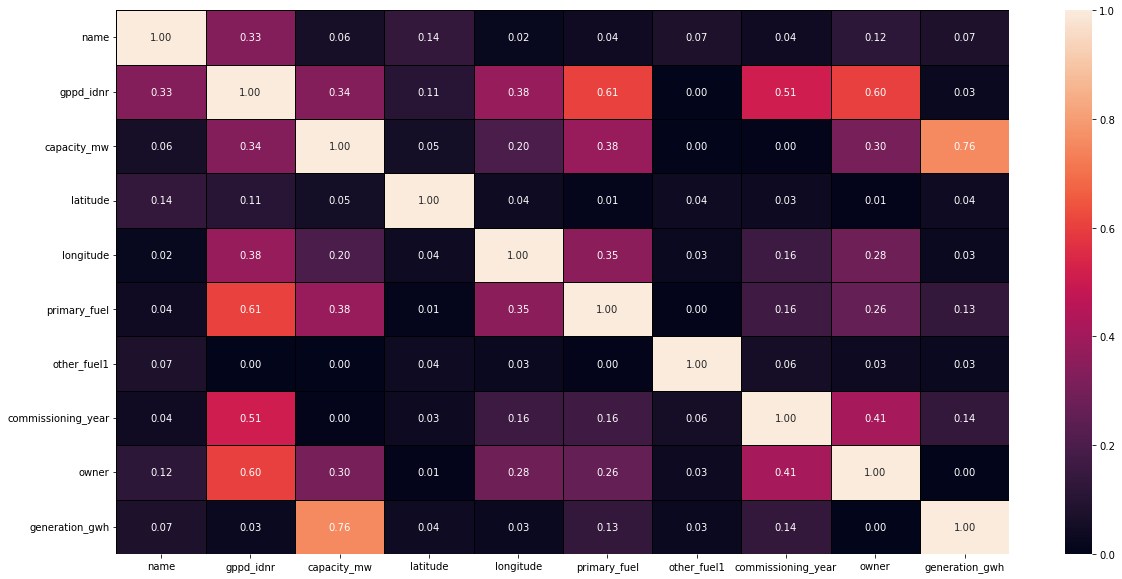

In [238]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr().abs(),annot=True,linewidth=0.5,linecolor='black',fmt='.2f')

Observation: We could observe there is no multicolliniarity.

## Outliers

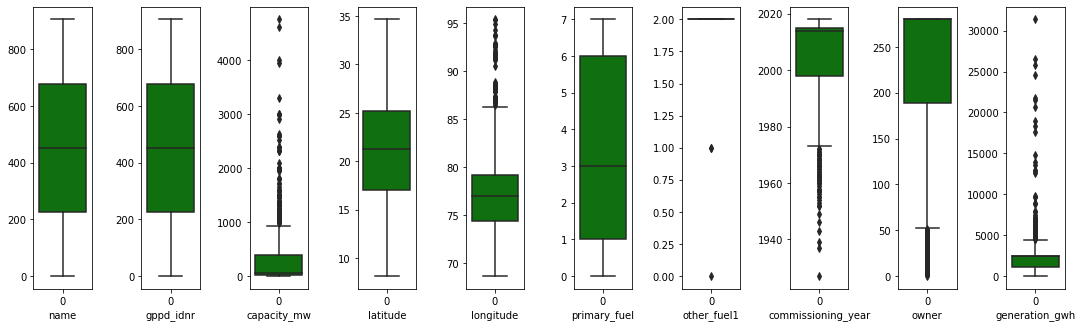

In [239]:
col=df.columns
plt.figure(figsize=(30,90))
for i in range(len(col)):
    plt.subplot(20,20,i+1)
    sns.boxplot(data=df[col[i]],color='green',orient='v')
    plt.xlabel(col[i])
    plt.tight_layout()

Observation: We could see outliers in capacity_mw, longitude, commissioning_year and generation_gwh

## Skewness

In [240]:
df.skew()

name                   0.000000
gppd_idnr              0.000000
capacity_mw            3.123576
latitude              -0.149698
longitude              1.141881
primary_fuel           0.472251
other_fuel1          -20.453120
commissioning_year    -1.714873
owner                 -1.373940
generation_gwh         5.219383
dtype: float64

observation: Considering skewness range as (-0.5,0.5), we could observe longitude,commisioning_year and generation_gwh are skewed. Lets check by generating dist plot.

## Treating outliers

In [20]:
xn=df.drop(['primary_fuel'],axis=1)
yn=df['primary_fuel']

In [21]:
xn.head()

,name,gppd_idnr,capacity_mw,latitude,longitude,other_fuel1,commissioning_year,owner,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018
0,0.0,657.0,2.5,28.1839,73.2407,2,2011.0,229.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
1,1.0,519.0,98.0,24.7663,74.6090,2,2015.0,258.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
2,2.0,853.0,39.2,21.9038,69.3732,2,2015.0,2.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
3,3.0,0.0,135.0,23.8712,91.3602,2,2004.0,280.0,617.789264,843.747000,886.004428,663.774500,626.239128
4,4.0,1.0,1800.0,21.9603,82.4091,2,2015.0,280.0,3035.550000,5916.370000,6243.000000,5385.579736,7279.000000


In [22]:
z=np.abs(zscore(xn))
i=np.where(z>3)
print("Outliers index-\n",set(i[0]))
print("\n\nNumber of rows to be eliminated-\n",len(set(i[0])))

Outliers index-
 {519, 648, 143, 15, 657, 786, 147, 788, 538, 541, 158, 416, 546, 807, 808, 427, 811, 813, 817, 818, 179, 308, 183, 695, 444, 573, 577, 706, 323, 709, 454, 583, 333, 847, 848, 209, 721, 340, 724, 342, 726, 728, 601, 222, 478, 482, 484, 360, 363, 364, 493, 494, 621, 880, 371, 244, 499, 375, 638, 767}


Number of rows to be eliminated-
 60


In [246]:
#Calculating Data Loss
loss=((907-53)/907)*100
print("The data loss-",100-loss,"%")

The data loss- 5.843439911797134 %


Observation: If we remove outliers 5.8% of data will be lost so we could bear this loss and will remove outlier rows.

In [23]:
#removing rows with outliers
xn=xn.drop(xn.index[i[0]])
xn

,name,gppd_idnr,capacity_mw,latitude,longitude,other_fuel1,commissioning_year,owner,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018
0,0.0,657.0,2.5,28.1839,73.2407,2,2011.0,229.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
1,1.0,519.0,98.0,24.7663,74.6090,2,2015.0,258.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
2,2.0,853.0,39.2,21.9038,69.3732,2,2015.0,2.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
3,3.0,0.0,135.0,23.8712,91.3602,2,2004.0,280.0,617.789264,843.747000,886.004428,663.774500,626.239128
4,4.0,1.0,1800.0,21.9603,82.4091,2,2015.0,280.0,3035.550000,5916.370000,6243.000000,5385.579736,7279.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,902.0,491.0,1600.0,16.2949,77.3568,2,2016.0,280.0,2431.823590,0.994875,233.596650,865.400000,686.500000
903,903.0,822.0,3.0,12.8932,78.1654,2,2015.0,114.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
904,904.0,891.0,25.5,15.2758,75.5811,2,2015.0,280.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099
905,905.0,539.0,80.0,24.3500,73.7477,2,2015.0,91.0,2431.823590,2428.226946,2467.936859,2547.759305,2600.804099


In [24]:
#removing rows with outliers
yn=yn.drop(yn.index[i[0]])
yn

0      6
1      1
2      7
3      2
4      1
      ..
902    1
903    6
904    7
905    1
906    7
Name: primary_fuel, Length: 847, dtype: int32

## Treating skewness

In [25]:
#using yeo-johnson transformation
xn=power_transform(xn,method='yeo-johnson')
xn

C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3202: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\user\anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\user\anaconda3\lib\site-packages\numpy\core\_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


array([[-2.16748339,  0.74329572, -1.67681976, ...,  0.35652887,
         0.35970372,  0.37195099],
       [-2.14634279,  0.28208878,  0.23351959, ...,  0.35652887,
         0.35970372,  0.37195099],
       [-2.1284088 ,  1.35742572, -0.26390819, ...,  0.35652887,
         0.35970372,  0.37195099],
       ...,
       [ 1.54105228,  1.47203225, -0.49824055, ...,  0.35652887,
         0.35970372,  0.37195099],
       [ 1.54389743,  0.35073327,  0.12386056, ...,  0.35652887,
         0.35970372,  0.37195099],
       [ 1.5467416 ,  1.42694694, -0.73433912, ...,  0.35652887,
         0.35970372,  0.37195099]])

## Standardisation of data

In [26]:
scaler=StandardScaler()
xn=scaler.fit_transform(xn)
xn

array([[-2.16748339,  0.74329572, -1.67681976, ...,  0.35652887,
         0.35970372,  0.37195099],
       [-2.14634279,  0.28208878,  0.23351959, ...,  0.35652887,
         0.35970372,  0.37195099],
       [-2.1284088 ,  1.35742572, -0.26390819, ...,  0.35652887,
         0.35970372,  0.37195099],
       ...,
       [ 1.54105228,  1.47203225, -0.49824055, ...,  0.35652887,
         0.35970372,  0.37195099],
       [ 1.54389743,  0.35073327,  0.12386056, ...,  0.35652887,
         0.35970372,  0.37195099],
       [ 1.5467416 ,  1.42694694, -0.73433912, ...,  0.35652887,
         0.35970372,  0.37195099]])

In [253]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
max_ac=0
randomState=0
lr=LogisticRegression()
for i in range(500):
    x_train,x_test,y_train,y_test=train_test_split(xn,yn,random_state=i,test_size=0.20)
    lr.fit(x_train,y_train)
    pred_train=lr.predict(x_train)
    pred_test=lr.predict(x_test)
    if round(accuracy_score(y_train,pred_train)*100,1)==round(accuracy_score(y_test,pred_test)*100,1):
        print("\n\nAt random state:",i)
        print("\nTrain Accuracy- ",round(accuracy_score(y_train,pred_train)*100,1))
        print("\nTest Accuracy- ",round(accuracy_score(y_test,pred_test)*100,1))
        if round(accuracy_score(y_test,pred_test)*100,1)>max_ac:
            randomState=i
            max_ac=round(accuracy_score(y_test,pred_test)*100,1)
print("\n\n Best accuracy at random state-",randomState)



At random state: 4

Train Accuracy-  72.9

Test Accuracy-  72.9


At random state: 70

Train Accuracy-  72.9

Test Accuracy-  72.9


At random state: 143

Train Accuracy-  72.4

Test Accuracy-  72.4


At random state: 199

Train Accuracy-  71.8

Test Accuracy-  71.8


At random state: 305

Train Accuracy-  72.9

Test Accuracy-  72.9


At random state: 357

Train Accuracy-  71.8

Test Accuracy-  71.8


At random state: 363

Train Accuracy-  72.4

Test Accuracy-  72.4


At random state: 389

Train Accuracy-  72.4

Test Accuracy-  72.4


 Best accuracy at random state- 4


## Logistic Regression

In [254]:
x_train,x_test,y_train,y_test=train_test_split(xn,yn,random_state=4,test_size=0.20)
lr.fit(x_train,y_train)
pred_train=lr.predict(x_train)
pred_test=lr.predict(x_test)
train_accuracy=round(accuracy_score(y_train,pred_train)*100,1)
test_accuracy=round(accuracy_score(y_test,pred_test)*100,1)
print("\ntrain accuracy-",train_accuracy)
print("\ntest accuracy-",test_accuracy)


train accuracy- 72.9

test accuracy- 72.9


## Cross validation score

In [255]:
for i in range(4,20):
    cv_score=cross_val_score(lr,xn,yn,cv=i)
    cv_mean=cv_score.mean()
    print("\n\nAt cv-",i)
    print("\n cross validation score is-",cv_mean*100)
    print("\n Accuracy score is-",test_accuracy)



At cv- 4

 cross validation score is- 70.99056603773585

 Accuracy score is- 72.9


At cv- 5

 cross validation score is- 70.5123564218587

 Accuracy score is- 72.9


At cv- 6

 cross validation score is- 70.39256817500748

 Accuracy score is- 72.9


At cv- 7

 cross validation score is- 70.98631621731474

 Accuracy score is- 72.9


At cv- 8

 cross validation score is- 71.69811320754717

 Accuracy score is- 72.9


At cv- 9

 cross validation score is- 71.68470822446187

 Accuracy score is- 72.9


At cv- 10

 cross validation score is- 71.69327731092436

 Accuracy score is- 72.9


At cv- 11

 cross validation score is- 71.69345805709443

 Accuracy score is- 72.9


At cv- 12

 cross validation score is- 71.21562709590879

 Accuracy score is- 72.9


At cv- 13

 cross validation score is- 71.56535771920386

 Accuracy score is- 72.9


At cv- 14

 cross validation score is- 71.68227946916471

 Accuracy score is- 72.9


At cv- 15

 cross validation score is- 71.21762740183793

 Accuracy sc

So we are getting the least difference between cross_val_score and accuracy score at cv=14

In [256]:
cv_score_best_lr=cross_val_score(lr,xn,yn,cv=14).mean()*100
print("cross validation score is-",cv_score_best_lr)
print("accuracy score for linear regression model is-",test_accuracy)

cross validation score is- 71.68227946916471
accuracy score for linear regression model is- 72.9


## Generating Confusion Matrix

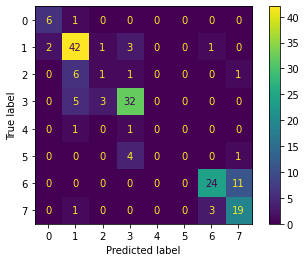

In [258]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_test)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0','1','2','3','4','5','6','7'])
cm.plot()
plt.show()

## Decision Tree Classifier

In [260]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
for i in range(500):
    x_train,x_test,y_train,y_test=train_test_split(xn,yn,random_state=i,test_size=0.20)
    dt.fit(x_train,y_train)
    dt_pred_train=dt.predict(x_train)
    dt_pred_test=dt.predict(x_test)
    dt_acc_train=round(accuracy_score(y_train,dt_pred_train)*100,1)
    dt_acc_test=round(accuracy_score(y_test,dt_pred_test)*100,1)
    print("\n at random state",i)
    print("acc train",dt_acc_train)
    print("acc test",dt_acc_test)


 at random state 0
acc train 100.0
acc test 78.8

 at random state 1
acc train 100.0
acc test 81.2

 at random state 2
acc train 100.0
acc test 76.5

 at random state 3
acc train 100.0
acc test 80.6

 at random state 4
acc train 100.0
acc test 87.6

 at random state 5
acc train 100.0
acc test 78.8

 at random state 6
acc train 100.0
acc test 80.6

 at random state 7
acc train 100.0
acc test 74.7

 at random state 8
acc train 100.0
acc test 84.1

 at random state 9
acc train 100.0
acc test 82.4

 at random state 10
acc train 100.0
acc test 74.7

 at random state 11
acc train 100.0
acc test 79.4

 at random state 12
acc train 100.0
acc test 80.6

 at random state 13
acc train 100.0
acc test 81.8

 at random state 14
acc train 100.0
acc test 80.0

 at random state 15
acc train 100.0
acc test 78.2

 at random state 16
acc train 100.0
acc test 78.8

 at random state 17
acc train 100.0
acc test 78.8

 at random state 18
acc train 100.0
acc test 82.4

 at random state 19
acc train 100.0
acc 

In [268]:
x_train,x_test,y_train,y_test=train_test_split(xn,yn,random_state=48,test_size=0.20)
dt.fit(x_train,y_train)
dt_pred_train=dt.predict(x_train)
dt_pred_test=dt.predict(x_test)
dt_acc_train=round(accuracy_score(y_train,dt_pred_train)*100,1)
dt_acc_test=round(accuracy_score(y_test,dt_pred_test)*100,1)
print("acc train",dt_acc_train)
print("acc test",dt_acc_test)

acc train 100.0
acc test 88.8


## Cross Validation Score

In [270]:
for i in range(4,15):
    cv_score=cross_val_score(dt,xn,yn,cv=i)
    cv_mean=cv_score.mean()
    print("\n\nAt cv-",i)
    print("\n cross validation score is-",cv_mean*100)
    print("\n Accuracy score is-",dt_acc_test)



At cv- 4

 cross validation score is- 75.0

 Accuracy score is- 88.8


At cv- 5

 cross validation score is- 76.29307344239471

 Accuracy score is- 88.8


At cv- 6

 cross validation score is- 78.64682182932108

 Accuracy score is- 88.8


At cv- 7

 cross validation score is- 78.54917065051191

 Accuracy score is- 88.8


At cv- 8

 cross validation score is- 79.12735849056605

 Accuracy score is- 88.8


At cv- 9

 cross validation score is- 80.05723528679857

 Accuracy score is- 88.8


At cv- 10

 cross validation score is- 80.65826330532214

 Accuracy score is- 88.8


At cv- 11

 cross validation score is- 79.83077528532074

 Accuracy score is- 88.8


At cv- 12

 cross validation score is- 82.77665995975858

 Accuracy score is- 88.8


At cv- 13

 cross validation score is- 81.36453290299445

 Accuracy score is- 88.8


At cv- 14

 cross validation score is- 80.19320843091336

 Accuracy score is- 88.8


So we are getting the least difference between cross_val_score and accuracy score at cv=12

In [272]:
cv_score_best_dt=cross_val_score(dt,xn,yn,cv=12).mean()*100
print("cross validation score is-",cv_score_best_dt)
print("accuracy score for decision tree classifier model is-",dt_acc_test)

cross validation score is- 82.18645204560698
accuracy score for decision tree classifier model is- 88.8


## Confusion Matrix

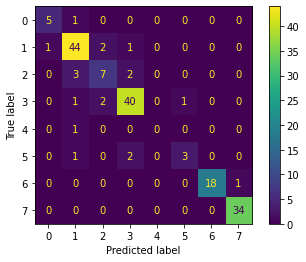

In [273]:
confusion_matrix = metrics.confusion_matrix(y_test, dt_pred_test)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0','1','2','3','4','5','6','7'])
cm.plot()
plt.show()

## Knn Classifier

In [274]:
from sklearn.neighbors import KNeighborsClassifier
max_ac=0
randomState=0
knn=KNeighborsClassifier()
for i in range(40):
    x_train,x_test,y_train,y_test=train_test_split(xn,yn,random_state=i,test_size=0.25)
    knn.fit(x_train,y_train)
    pred_train=knn.predict(x_train)
    pred_test=knn.predict(x_test)
    
    print("\n\nAt random state:",i)
    print("\nTrain Accuracy- ",round(accuracy_score(y_train,pred_train)*100,1))
    print("\nTest Accuracy- ",round(accuracy_score(y_test,pred_test)*100,1))
        
print("\n\n Best accuracy at random state-",randomState)



At random state: 0

Train Accuracy-  81.4

Test Accuracy-  69.8


At random state: 1

Train Accuracy-  81.9

Test Accuracy-  67.5


At random state: 2

Train Accuracy-  81.8

Test Accuracy-  72.2


At random state: 3

Train Accuracy-  82.1

Test Accuracy-  67.5


At random state: 4

Train Accuracy-  80.7

Test Accuracy-  71.2


At random state: 5

Train Accuracy-  80.8

Test Accuracy-  69.3


At random state: 6

Train Accuracy-  81.0

Test Accuracy-  74.1


At random state: 7

Train Accuracy-  81.8

Test Accuracy-  69.8


At random state: 8

Train Accuracy-  80.7

Test Accuracy-  74.1


At random state: 9

Train Accuracy-  81.0

Test Accuracy-  74.5


At random state: 10

Train Accuracy-  82.2

Test Accuracy-  67.0


At random state: 11

Train Accuracy-  81.6

Test Accuracy-  71.2


At random state: 12

Train Accuracy-  82.7

Test Accuracy-  77.4


At random state: 13

Train Accuracy-  79.9

Test Accuracy-  71.2


At random state: 14

Train Accuracy-  79.2

Test Accuracy-  71.2


At 

In [275]:
x_train,x_test,y_train,y_test=train_test_split(xn,yn,random_state=6,test_size=0.20)
knn.fit(x_train,y_train)
pred_train=knn.predict(x_train)
pred_test=knn.predict(x_test)
knn_train_acc=round(accuracy_score(y_train,pred_train)*100,1)
knn_test_acc=round(accuracy_score(y_test,pred_test)*100,1)
print("\nTrain Accuracy- ",knn_train_acc)
print("\nTest Accuracy- ",knn_test_acc)


Train Accuracy-  81.0

Test Accuracy-  75.9


## Cross Validation Score

In [276]:
for i in range(4,15):
    cv_score=cross_val_score(knn,xn,yn,cv=i)
    cv_mean=cv_score.mean()
    print("\n\nAt cv-",i)
    print("\n cross validation score is-",cv_mean*100)
    print("\n Accuracy score is-",knn_test_acc)



At cv- 4

 cross validation score is- 66.98113207547169

 Accuracy score is- 75.9


At cv- 5

 cross validation score is- 71.34006265227984

 Accuracy score is- 75.9


At cv- 6

 cross validation score is- 71.10678253920688

 Accuracy score is- 75.9


At cv- 7

 cross validation score is- 71.82147211953472

 Accuracy score is- 75.9


At cv- 8

 cross validation score is- 72.05188679245282

 Accuracy score is- 75.9


At cv- 9

 cross validation score is- 71.1123553564763

 Accuracy score is- 75.9


At cv- 10

 cross validation score is- 71.2170868347339

 Accuracy score is- 75.9


At cv- 11

 cross validation score is- 71.47549420276694

 Accuracy score is- 75.9


At cv- 12

 cross validation score is- 70.27833668678738

 Accuracy score is- 75.9


At cv- 13

 cross validation score is- 70.29765106688183

 Accuracy score is- 75.9


At cv- 14

 cross validation score is- 69.9199843871975

 Accuracy score is- 75.9


So we are getting the least difference between cross_val_score and accuracy score at cv=8

In [277]:
cv_score_best_knn=cross_val_score(knn,xn,yn,cv=8).mean()*100
print("cross validation score is-",cv_score_best_knn)
print("accuracy score for Knn classifier model is-",knn_test_acc)

cross validation score is- 72.05188679245282
accuracy score for Knn classifier model is- 75.9


## Confusion Matrix

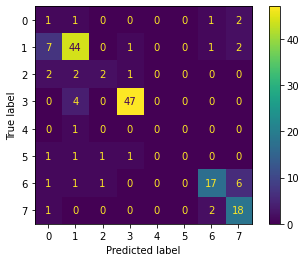

In [278]:
confusion_matrix = metrics.confusion_matrix(y_test,pred_test)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0','1','2','3','4','5','6','7'])
cm.plot()
plt.show()

## Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
max_ac=0
randomState=0

for i in range(40):
    x_train,x_test,y_train,y_test=train_test_split(xn,yn,random_state=i,test_size=0.25)
    rf.fit(x_train,y_train)
    pred_train=rf.predict(x_train)
    pred_test=rf.predict(x_test)
    
    print("\n\nAt random state:",i)
    print("\nTrain Accuracy- ",round(accuracy_score(y_train,pred_train)*100,1))
    print("\nTest Accuracy- ",round(accuracy_score(y_test,pred_test)*100,1))
        
print("\n\n Best accuracy at random state-",randomState)



At random state: 0

Train Accuracy-  100.0

Test Accuracy-  82.5


At random state: 1

Train Accuracy-  100.0

Test Accuracy-  82.5


At random state: 2

Train Accuracy-  100.0

Test Accuracy-  90.1


At random state: 3

Train Accuracy-  100.0

Test Accuracy-  80.2


At random state: 4

Train Accuracy-  100.0

Test Accuracy-  85.8


At random state: 5

Train Accuracy-  100.0

Test Accuracy-  83.0


At random state: 6

Train Accuracy-  100.0

Test Accuracy-  84.0


At random state: 7

Train Accuracy-  100.0

Test Accuracy-  84.4


At random state: 8

Train Accuracy-  100.0

Test Accuracy-  83.0


At random state: 9

Train Accuracy-  100.0

Test Accuracy-  88.7


At random state: 10

Train Accuracy-  100.0

Test Accuracy-  87.3


At random state: 11

Train Accuracy-  100.0

Test Accuracy-  91.0


At random state: 12

Train Accuracy-  100.0

Test Accuracy-  84.9


At random state: 13

Train Accuracy-  100.0

Test Accuracy-  85.8


At random state: 14

Train Accuracy-  100.0

Test Accura

In [322]:
x_train,x_test,y_train,y_test=train_test_split(xn,yn,random_state=6,test_size=0.20)
rf.fit(x_train,y_train)
pred_train=rf.predict(x_train)
pred_test=rf.predict(x_test)
rf_train_acc=round(accuracy_score(y_train,pred_train)*100,1)
rf_test_acc=round(accuracy_score(y_test,pred_test)*100,1)
print("\nTrain Accuracy- ",rf_train_acc)
print("\nTest Accuracy- ",rf_test_acc)


Train Accuracy-  100.0

Test Accuracy-  88.2


## Cross Validation Score

In [324]:
for i in range(4,20):
    cv_score=cross_val_score(rf,xn,yn,cv=i)
    cv_mean=cv_score.mean()
    print("\n\nAt cv-",i)
    print("\n cross validation score is-",cv_mean*100)
    print("\n Accuracy score is-",rf_test_acc)



At cv- 4

 cross validation score is- 82.0754716981132

 Accuracy score is- 88.2


At cv- 5

 cross validation score is- 83.59902540898017

 Accuracy score is- 88.2


At cv- 6

 cross validation score is- 83.60303665967436

 Accuracy score is- 88.2


At cv- 7

 cross validation score is- 83.25720479222713

 Accuracy score is- 88.2


At cv- 8

 cross validation score is- 84.78773584905662

 Accuracy score is- 88.2


At cv- 9

 cross validation score is- 83.72402637800174

 Accuracy score is- 88.2


At cv- 10

 cross validation score is- 85.01260504201682

 Accuracy score is- 88.2


At cv- 11

 cross validation score is- 83.9645203281567

 Accuracy score is- 88.2


At cv- 12

 cross validation score is- 84.53554661301142

 Accuracy score is- 88.2


At cv- 13

 cross validation score is- 84.79469248700019

 Accuracy score is- 88.2


At cv- 14

 cross validation score is- 85.48594847775176

 Accuracy score is- 88.2


At cv- 15

 cross validation score is- 85.25271512113616

 Accuracy sco

So we are getting the least difference between cross_val_score and accuracy score at cv=19

In [326]:
cv_score_best_rf=cross_val_score(rf,xn,yn,cv=19).mean()*100
print("cross validation score is-",cv_score_best_rf)
print("accuracy score for random forest classifier model is-",rf_test_acc)

cross validation score is- 85.82402977139819
accuracy score for random forest classifier model is- 88.2


## Confusion Matrix

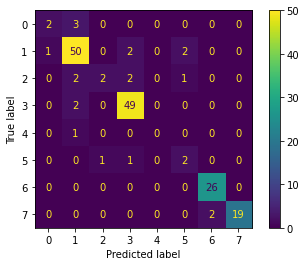

In [327]:
confusion_matrix = metrics.confusion_matrix(y_test,pred_test)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0','1','2','3','4','5','6','7'])
cm.plot()
plt.show()

## Model Summary

In [328]:
models=['Logistic Regression','Decision Tree Classifier','Knn Classifier','Random Forest Classifier']
test_acc=[test_accuracy,dt_acc_test,knn_test_acc,rf_test_acc]
cv_score=[cv_score_best_lr,cv_score_best_dt,cv_score_best_knn,cv_score_best_rf]
df2=pd.DataFrame(list(zip(models,test_acc,cv_score)),columns=['Models','Test Accuracy','CV Score'])
df2

,Models,Test Accuracy,CV Score
0,Logistic Regression,72.9,71.682279
1,Decision Tree Classifier,88.8,82.186452
2,Knn Classifier,75.9,72.051887
3,Random Forest Classifier,88.2,85.824030


## Looking at athe above table the best performing model is random forest classifier so we will perform hyper parameter tuning on this.

## Hyperparameter tuning

In [30]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000] 
}

rf_reg = RandomForestClassifier()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(x_train, y_train)
rf_reg_tuned.best_estimator_

Fitting 3 folds for each of 1980 candidates, totalling 5940 fits


RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=5,
                       n_estimators=600)

In [37]:
rf1=RandomForestClassifier(n_estimators=600,max_depth=10,min_samples_split=5,bootstrap=False)
rf1.fit(x_train,y_train)
pred_train=rf1.predict(x_train)
pred_test=rf1.predict(x_test)
train_acc=round(accuracy_score(y_train,pred_train)*100,1)
test_acc=round(accuracy_score(y_test,pred_test)*100,1)
print("\nTrain Accuracy- ",train_acc)
print("\nTest Accuracy- ",test_acc)


Train Accuracy-  99.5

Test Accuracy-  84.4


Accuracy didnot improve so we will save previous rf model.

In [38]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(rf, open(filename, 'wb'))